In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
df = pd.read_csv('./dataset/processed_dataset.csv')

In [3]:
# Separate features and target
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [7]:
# Feature selection
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test_scaled)

C:\Users\Phat PC\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=8. All the features will be returned.
  warnings.warn(


In [8]:
# Create model
def create_model(input_dim, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(),
                         tf.keras.metrics.Recall(),
                         tf.keras.metrics.AUC()])
    return model

In [9]:
# Create and train model with early stopping
model = create_model(X_train_selected.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_selected, y_train_balanced,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

C:\Users\Phat PC\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3070/3070 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8628 - auc: 0.9408 - loss: 0.2890 - precision: 0.8135 - recall: 0.8282 - val_accuracy: 0.8568 - val_auc: 0.0000e+00 - val_loss: 0.3024 - val_precision: 1.0000 - val_recall: 0.8568
Epoch 2/100
3070/3070 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9059 - auc: 0.9728 - loss: 0.1974 - precision: 0.8834 - recall: 0.8600 - val_accuracy: 0.8855 - val_auc: 0.0000e+00 - val_loss: 0.2567 - val_precision: 1.0000 - val_recall: 0.8855
Epoch 3/100
3070/3070 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9084 - auc: 0.9750 - loss: 0.1878 - precision: 0.8823 - recall: 0.8715 - val_accuracy: 0.8891 - val_auc: 0.0000e+00 - val_loss: 0.2388 - val_precision: 1.0000 - val_recall: 0.8891
Epoch 4/100
3070/3070 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9104 - auc: 0.9765 - loss: 0.1812 - precision: 0.8845 - recall: 0.8743 - val_accuracy: 0.8974 - val_auc: 0.0000e+00 - val_loss: 0.2351 - val_precision: 1.0000 - val_recall: 0.8974
Epoc

In [10]:
# Make predictions
y_pred_proba = model.predict(X_test_selected)
y_pred = (y_pred_proba > 0.5).astype(int)

902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step


In [11]:
# Make predictions
y_pred_proba = model.predict(X_test_selected)
y_pred = (y_pred_proba > 0.5).astype(int)

902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step


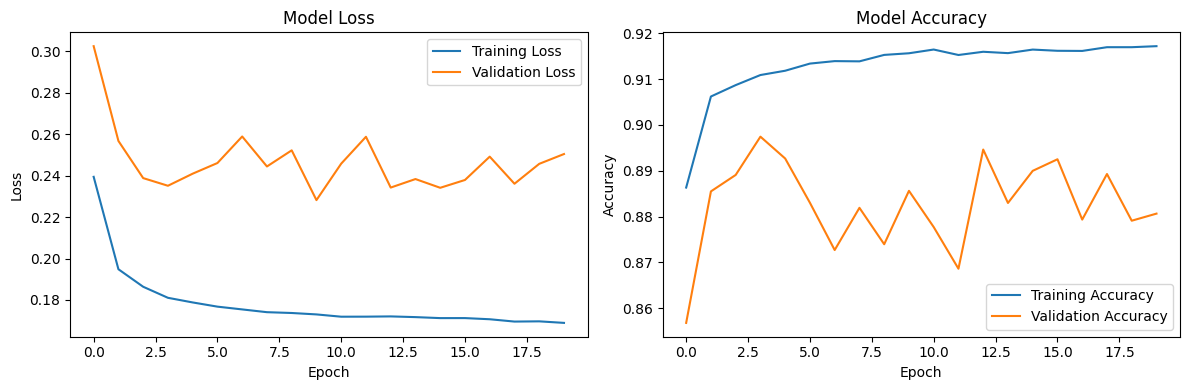

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

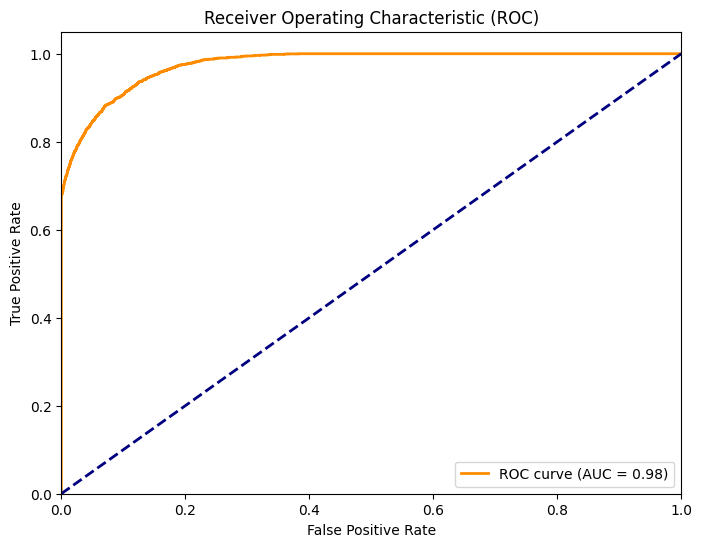

In [13]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

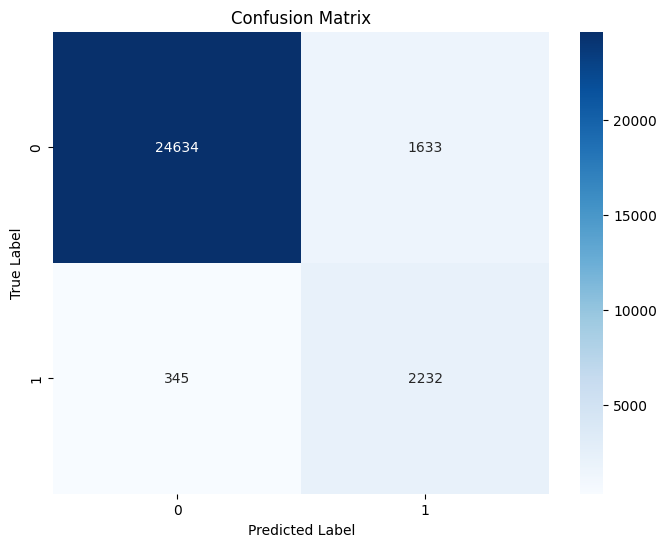

In [14]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step
902/902 ━━━

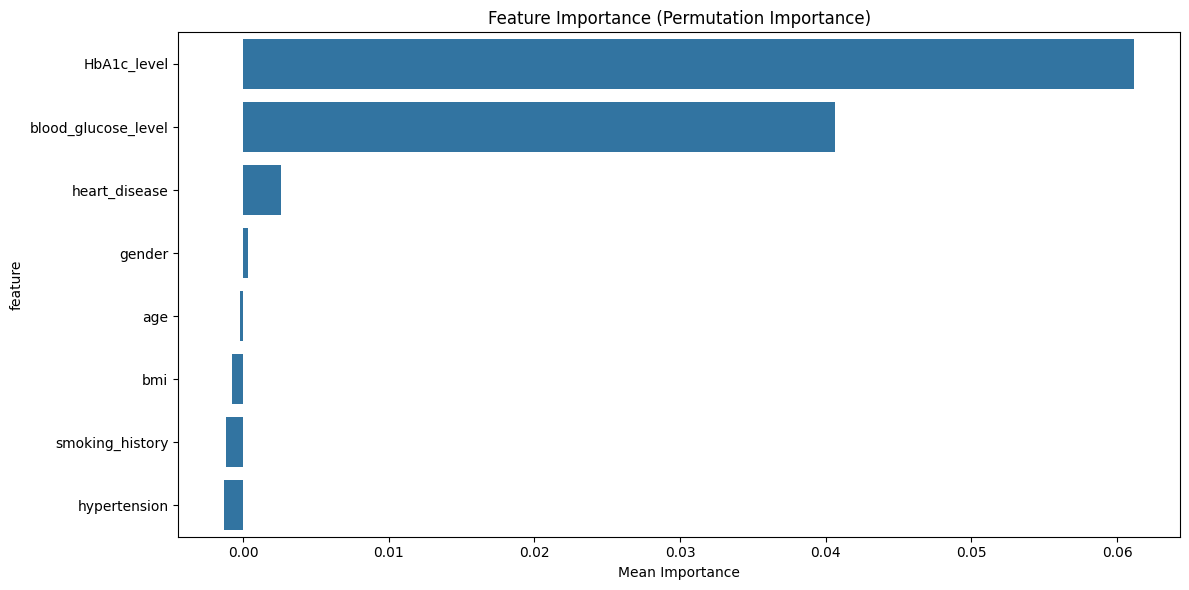

In [17]:
# Plot Feature Importance
# Using permutation importance
from sklearn.inspection import permutation_importance

def custom_scorer(estimator, X, y):
    y_pred = (estimator.predict(X) > 0.5).astype(int)
    return accuracy_score(y, y_pred)

perm_importance = permutation_importance(
    model,
    X_test_selected,
    y_test,
    scoring=custom_scorer,  
    n_repeats=10,
    random_state=42
)

selected_features = X.columns[selector.get_support()].tolist()
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': perm_importance.importances_mean
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Mean Importance')
plt.tight_layout()
plt.show()

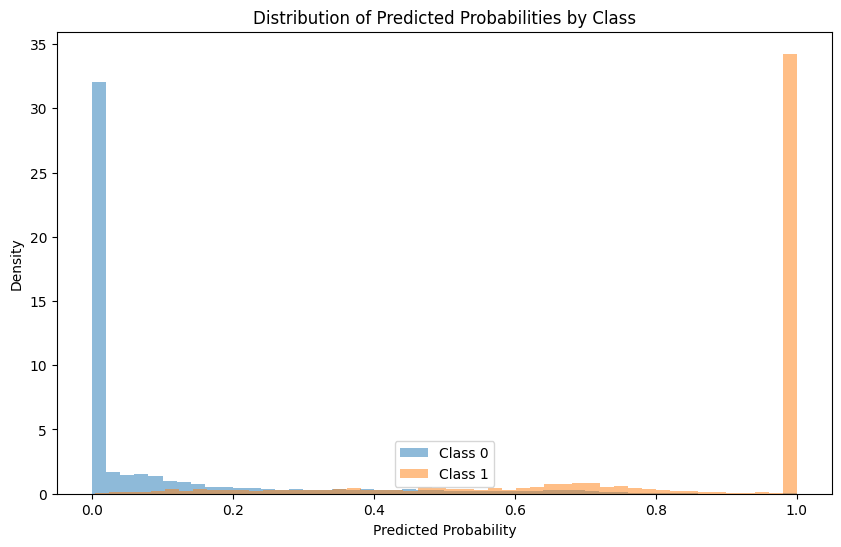

In [18]:
# Plot prediction probability distribution
plt.figure(figsize=(10, 6))
for i in range(2):
    mask = y_test == i
    plt.hist(y_pred_proba[mask], bins=50, alpha=0.5, 
             label=f'Class {i}', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities by Class')
plt.legend()
plt.show()

C:\Users\Phat PC\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


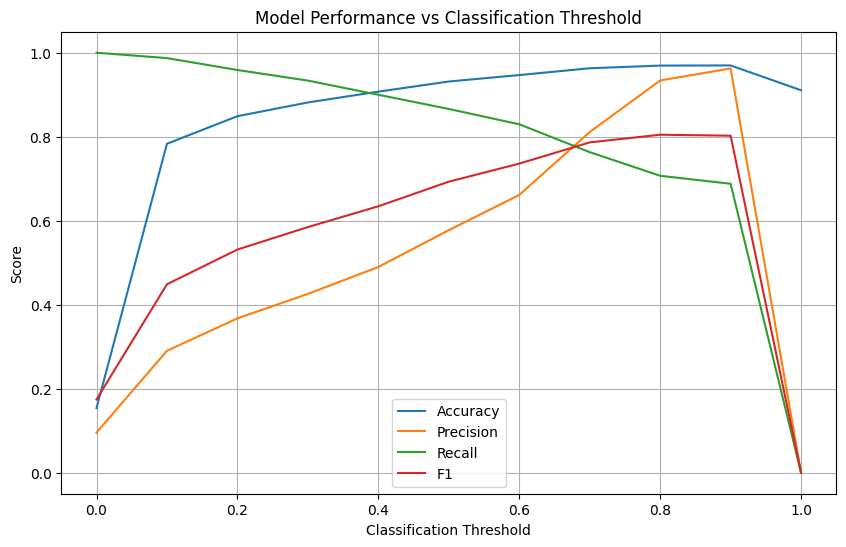

In [20]:
# Evaluate model performance at different thresholds
from sklearn.metrics import f1_score, precision_score, recall_score


thresholds = np.arange(0, 1.1, 0.1)
scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba > threshold).astype(int)
    scores.append({
        'threshold': threshold,
        'accuracy': accuracy_score(y_test, y_pred_threshold),
        'precision': precision_score(y_test, y_pred_threshold),
        'recall': recall_score(y_test, y_pred_threshold),
        'f1': f1_score(y_test, y_pred_threshold)
    })

scores_df = pd.DataFrame(scores)

plt.figure(figsize=(10, 6))
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.plot(scores_df['threshold'], scores_df[metric], label=metric.capitalize())
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Model Performance vs Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Print model summary
print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,605 (37.52 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,404 (25.02 KB)

In [22]:
# Print final metrics
print("\nFinal Metrics:")
print(f"AUC-ROC: {roc_auc:.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Best Validation Loss: {min(history.history['val_loss']):.3f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.3f}")


Final Metrics:
AUC-ROC: 0.976
Accuracy: 0.931
Best Validation Loss: 0.228
Best Validation Accuracy: 0.897
